In [1]:
import os
import sys

import numpy.version
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pickle
import time

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras import layers
#import keras



from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tqdm.auto import trange, tqdm

import annutils

In [2]:
# If shap hasn't been installed, uncomment the following line:
#%pip install shap

In [3]:

import shap

shap.initjs()  # In Colab we apparently need to initjs for shap in each cell,
# normally just do it once
# should show a little hexagon with 'js' in it

In [4]:
# load our model
local_root_path= "."

ndays=118
window_size=0
nwindows=0
model_str_def = "residual_lstm_8_2"
scenario_name = 'Tune_RSAC_RSAN'

full_model_str_def = 'i%d_'%(ndays + nwindows) + model_str_def
model_path_prefix = "mtl_%s_%s" % (full_model_str_def, scenario_name)
#  mtl_i118_residual_lstm_8_2_Tune_RSAC_RSAN

print(model_path_prefix)


'''
Lists of training and validation sets
'''
train_data = ["dsm2_ann_inputs_rsacminus15day.xlsx",
              "dsm2_ann_inputs_rsacminus20pct.xlsx",
              "dsm2_ann_inputs_rsacplus15day.xlsx",
              "dsm2_ann_inputs_rsacplus20pct.xlsx",
              "dsm2_ann_inputs_rsanminus15day.xlsx",
              "dsm2_ann_inputs_rsanminus20pct.xlsx",
              "dsm2_ann_inputs_rsanplus15day.xlsx",
              "dsm2_ann_inputs_rsanplus20pct.xlsx",
              ]
val_data = "dsm2_ann_inputs_base.xlsx"

'''
Dictionary of test sets
- keys: test scenario name
- values: names of excel files
'''
test_data = {'dcc0': "dsm2_ann_inputs_dcc0.xlsx",
             'smscg1': "dsm2_ann_inputs_smscg1.xlsx",
             'dcc1': "dsm2_ann_inputs_dcc1.xlsx",
             'smscg0': "dsm2_ann_inputs_smscg0.xlsx"}

num_sheets = 9

observed_stations_ordered_by_median = ['RSMKL008', 'RSAN032', 'RSAN037', 'RSAC092', 'SLTRM004', 'ROLD024',
                                       'CHVCT000', 'RSAN018', 'CHSWP003', 'CHDMC006', 'SLDUT007', 'RSAN072',
                                       'OLD_MID', 'RSAN058', 'ROLD059', 'RSAN007', 'RSAC081', 'SLMZU025',
                                       'RSAC075', 'SLMZU011', 'SLSUS012', 'SLCBN002', 'RSAC064']

'''
Dictionary of extra test set(s)
- keys: test scenario name
- values: names of excel files
'''
extra_data = {'observed': "observed_data_daily.xlsx"}

'''
Ratio to split the extra dataset for test
'''
extra_data_test_ratio = 0.3
'''
Which part of extra dataset used for for test
Available options: {'first', 'last', 'middle', 'manual'}
'''

which_part_for_test = 'last'
# which_part_for_test = 'manual'

# manually picked years for "training" in observed dataset
# if which_part_for_test == 'manual', years not listed below will be used
# for testing and results will be saved with '_observed' suffix in the
# pickle file
picked_training_years = [
	('2007-10-1', '2008-9-30'),
	('2008-10-1', '2009-9-30'),
	('2010-10-1', '2011-9-30'),
	('2011-10-1', '2012-9-30'),
	('2013-10-1', '2014-9-30'),
	('2016-10-1', '2017-9-30')
]


mtl_i118_residual_lstm_8_2_Tune_RSAC_RSAN


In [5]:
def mse_loss_masked(y_true, y_pred):
	squared_diff = tf.reduce_sum(tf.math.squared_difference(y_pred[y_true>0],y_true[y_true>0]))
	return squared_diff/(tf.reduce_sum(tf.cast(y_true>0, tf.float32))+0.01)

loaded_model = annutils.load_model(os.path.join(local_root_path,'models', model_path_prefix),custom_objects={"mse_loss_masked": mse_loss_masked})




In [6]:
xscaler = loaded_model.xscaler
yscaler = loaded_model.yscaler

In [7]:
def read_training_data(train_data):
	x_train = None
	y_train = None
	for data_file in tqdm(train_data):
		data_path = os.path.join(local_root_path, data_file)
		dfinps, dfouts = annutils.read_and_split(data_path, num_sheets, observed_stations_ordered_by_median)

		# create tuple of calibration and validation sets and the xscaler and yscaler on the combined inputs
		if x_train is None:
			(x_train, y_train), (_, _), _, _ = \
				annutils.create_training_sets([dfinps],
				                              [dfouts],
				                              train_frac=1,
				                              ndays=ndays, window_size=window_size, nwindows=nwindows,
				                              xscaler=xscaler, yscaler=yscaler)
		else:
			(xc, yc), (_, _), _, _ = \
				annutils.create_training_sets([dfinps],
				                              [dfouts],
				                              train_frac=1,
				                              ndays=ndays, window_size=window_size, nwindows=nwindows,
				                              xscaler=xscaler, yscaler=yscaler)
			x_train = pd.concat([x_train, xc], axis=0)
			y_train = pd.concat([y_train, yc], axis=0)
			del xc, yc
	return x_train, y_train

def read_validation_data(val_data):
	data_path = os.path.join(local_root_path, val_data)
	dfinps, dfouts = annutils.read_and_split(data_path, num_sheets, observed_stations_ordered_by_median)

	# create tuple of calibration and validation sets and the xscaler and yscaler on the combined inputs
	(x_val, y_val), (_, _), _, _ = \
		annutils.create_training_sets([dfinps],
		                              [dfouts],
		                              train_frac=1,
		                              ndays=ndays, window_size=window_size, nwindows=nwindows,
		                              xscaler=xscaler, yscaler=yscaler)
	return x_val, y_val

def read_test_data(test_data):
	x_test = None
	y_test = None
	for data_file in tqdm(test_data.values()):
		data_path = os.path.join(local_root_path, data_file)
		dfinps, dfouts = annutils.read_and_split(data_path, num_sheets, observed_stations_ordered_by_median)

		# create tuple of calibration and validation sets and the xscaler and yscaler on the combined inputs
		if x_test is None:
			(x_test, y_test), (_, _), _, _ = \
				annutils.create_training_sets([dfinps],
				                              [dfouts],
				                              train_frac=1,
				                              ndays=ndays, window_size=window_size, nwindows=nwindows,
				                              xscaler=xscaler, yscaler=yscaler)
		else:
			(xt, yt), (_, _), _, _ = \
				annutils.create_training_sets([dfinps],
				                              [dfouts],
				                              train_frac=1,
				                              ndays=ndays, window_size=window_size, nwindows=nwindows,
				                              xscaler=xscaler, yscaler=yscaler)
			x_test = pd.concat([x_test, xt], axis=0)
			y_test = pd.concat([y_test, yt], axis=0)
	return x_test, y_test

In [8]:

xallc, yallc = read_training_data(train_data)
xallv, yallv = read_validation_data(val_data)
xallt, yallt = read_test_data(test_data)





  0%|          | 0/8 [00:00<?, ?it/s]

Randomly selecting 10803 samples for training, 0 for test
Randomly selecting 10803 samples for training, 0 for test
Randomly selecting 10803 samples for training, 0 for test
Randomly selecting 10803 samples for training, 0 for test
Randomly selecting 10803 samples for training, 0 for test
Randomly selecting 10803 samples for training, 0 for test
Randomly selecting 10803 samples for training, 0 for test
Randomly selecting 10803 samples for training, 0 for test
Randomly selecting 10803 samples for training, 0 for test


  0%|          | 0/4 [00:00<?, ?it/s]

Randomly selecting 10803 samples for training, 0 for test
Randomly selecting 10803 samples for training, 0 for test
Randomly selecting 10803 samples for training, 0 for test
Randomly selecting 10803 samples for training, 0 for test


In [9]:
######### Read extra observed dataset ###############
for data_file in tqdm(extra_data.values()):
	data_path = os.path.join(local_root_path, data_file)

	# print("Starting read_excel calls:", data_path)
	dflist = [annutils.read_excel_sheet(data_path, i) for i in range(num_sheets)]

	df_inpout = pd.concat(dflist[0:num_sheets], axis=1).dropna(axis=0)
	col_mask = df_inpout.columns.isin(dflist[num_sheets - 1].columns)
	dfinps = df_inpout.loc[:, ~col_mask]
	dfouts = df_inpout.loc[:, col_mask]
	# dfouts = dfouts[output_stations]  # out_stations is None here...

	start_year = max(dfinps.index[0].year, dfouts.index[0].year)
	end_year = min(dfinps.index[-1].year, dfouts.index[-1].year)

	if which_part_for_test == 'last':
		calib_slice = slice(str(start_year),
		                    str(int(start_year + (1 - extra_data_test_ratio) * (end_year - start_year))))
		valid_slice = slice(str(int(start_year + (1 - extra_data_test_ratio) * (end_year - start_year)) + 1),
		                    str(end_year))
	elif which_part_for_test == 'first':
		calib_slice = slice(str(int(start_year + (1 - extra_data_test_ratio) * (end_year - start_year)) + 1),
		                    str(end_year))
		valid_slice = slice(str(start_year),
		                    str(int(start_year + (1 - extra_data_test_ratio) * (end_year - start_year))))
	elif which_part_for_test == 'middle':
		calib_slice = [slice(str(start_year),
		                     str(int(start_year + (1 - extra_data_test_ratio) / 2 * (end_year - start_year)))),
		               slice(str(int(start_year + (1 + extra_data_test_ratio) / 2 * (end_year - start_year) + 1)),
		                     str(end_year))]
		valid_slice = slice(str(int(start_year + (1 - extra_data_test_ratio) / 2 * (end_year - start_year)) + 1),
		                    str(int(start_year + (1 + extra_data_test_ratio) / 2 * (end_year - start_year))))
	elif which_part_for_test == 'manual' and picked_training_years is not None:
		calib_slice = [slice(str(start_year), str(end_year)) for (start_year, end_year) in picked_training_years]
		valid_slice = [slice(start_year, end_year) for ((_, start_year), (end_year, _)) in
		               zip([(None, '1989-10-1'), ] + picked_training_years,
		                   picked_training_years + [('2020-9-30', None), ])]
	else:
		raise Exception('Unknown data splitting method')

	# create tuple of calibration and validation sets and the xscaler and yscaler on the combined inputs
	(x_extra_train, y_extra_train), (x_extra_test, y_extra_test), _, _ = \
		annutils.create_training_sets([dfinps],
		                              [dfouts],
		                              calib_slice=calib_slice,
		                              valid_slice=valid_slice,
		                              ndays=ndays, window_size=window_size, nwindows=nwindows,
		                              xscaler=xscaler, yscaler=yscaler)
	xallc = pd.concat([xallc, x_extra_train], axis=0)
	yallc = pd.concat([yallc, y_extra_train], axis=0)
	xallt = pd.concat([xallt, x_extra_test], axis=0)
	yallt = pd.concat([yallt, y_extra_test], axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:

if which_part_for_test == "manual":
	print('Training set input shape was: ', xallc.shape)
	xallc = annutils.include(xallc, picked_training_years)
	print('Training set input shape now: ', xallc.shape)
	yallc = annutils.include(yallc, picked_training_years)

print('Training set input shape: ', xallc.shape)
print('Validation set input shape: ', xallv.shape)
print('Test set input shape: ', xallt.shape)

print('Output shape: ', yallc.shape[1:])

Training set input shape:  (91421, 944)
Validation set input shape:  (10803, 944)
Test set input shape:  (45403, 944)
Output shape:  (23,)


In [57]:
# data = xallc.iloc[:50,:]

kernel_data = shap.sample(xallc, 63)

explainer = shap.KernelExplainer(loaded_model.model.predict, kernel_data )

to_explain = shap.sample(xallt, 71)

shap_values = explainer.shap_values(to_explain, nsamples=475)
# shap_values = explainer.shap_values(xallt.iloc[299,:], nsamples=666)
#shap_values = explainer.shap_values(xallt, nsamples=475)
# tempX = xallt.iloc[299,:]

################
# shap_values  Returns
# -------
# array or list
#     For models with a single output this returns a matrix of SHAP values
#     (# samples x # features). Each row sums to the difference between the model output for that
#     sample and the expected value of the model output (which is stored as expected_value
#     attribute of the explainer). For models with vector outputs this returns a list
#     of such matrices, one for each output.
# """

# we have a model that returns a vector.



2/2 [==============================] - 0s 3ms/step


  0%|          | 0/71 [00:00<?, ?it/s]

936/936 [==============================] - 2s 2ms/step


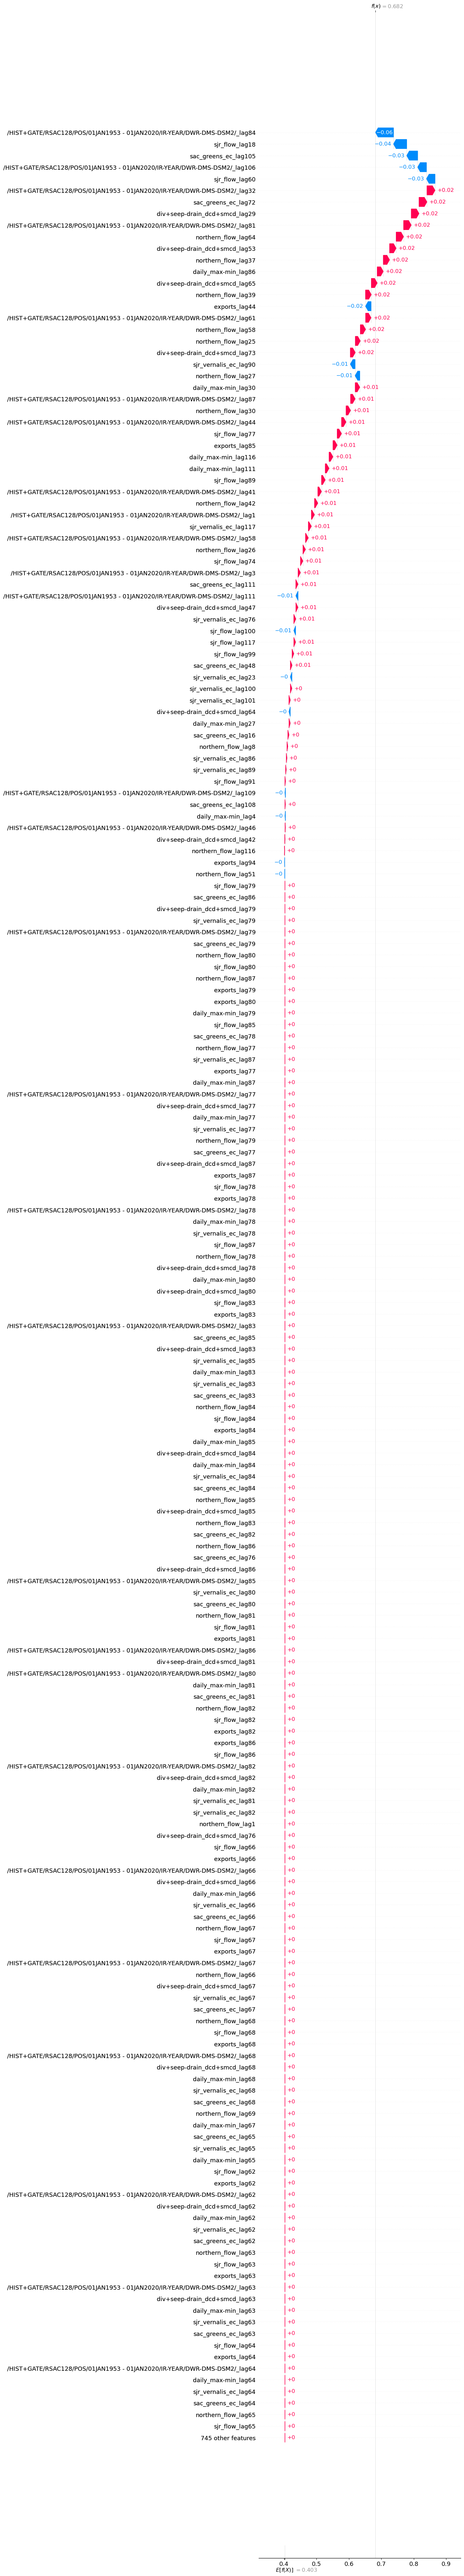

In [16]:
shap.initjs()

shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0], feature_names = xallt.columns, max_display = 200 )


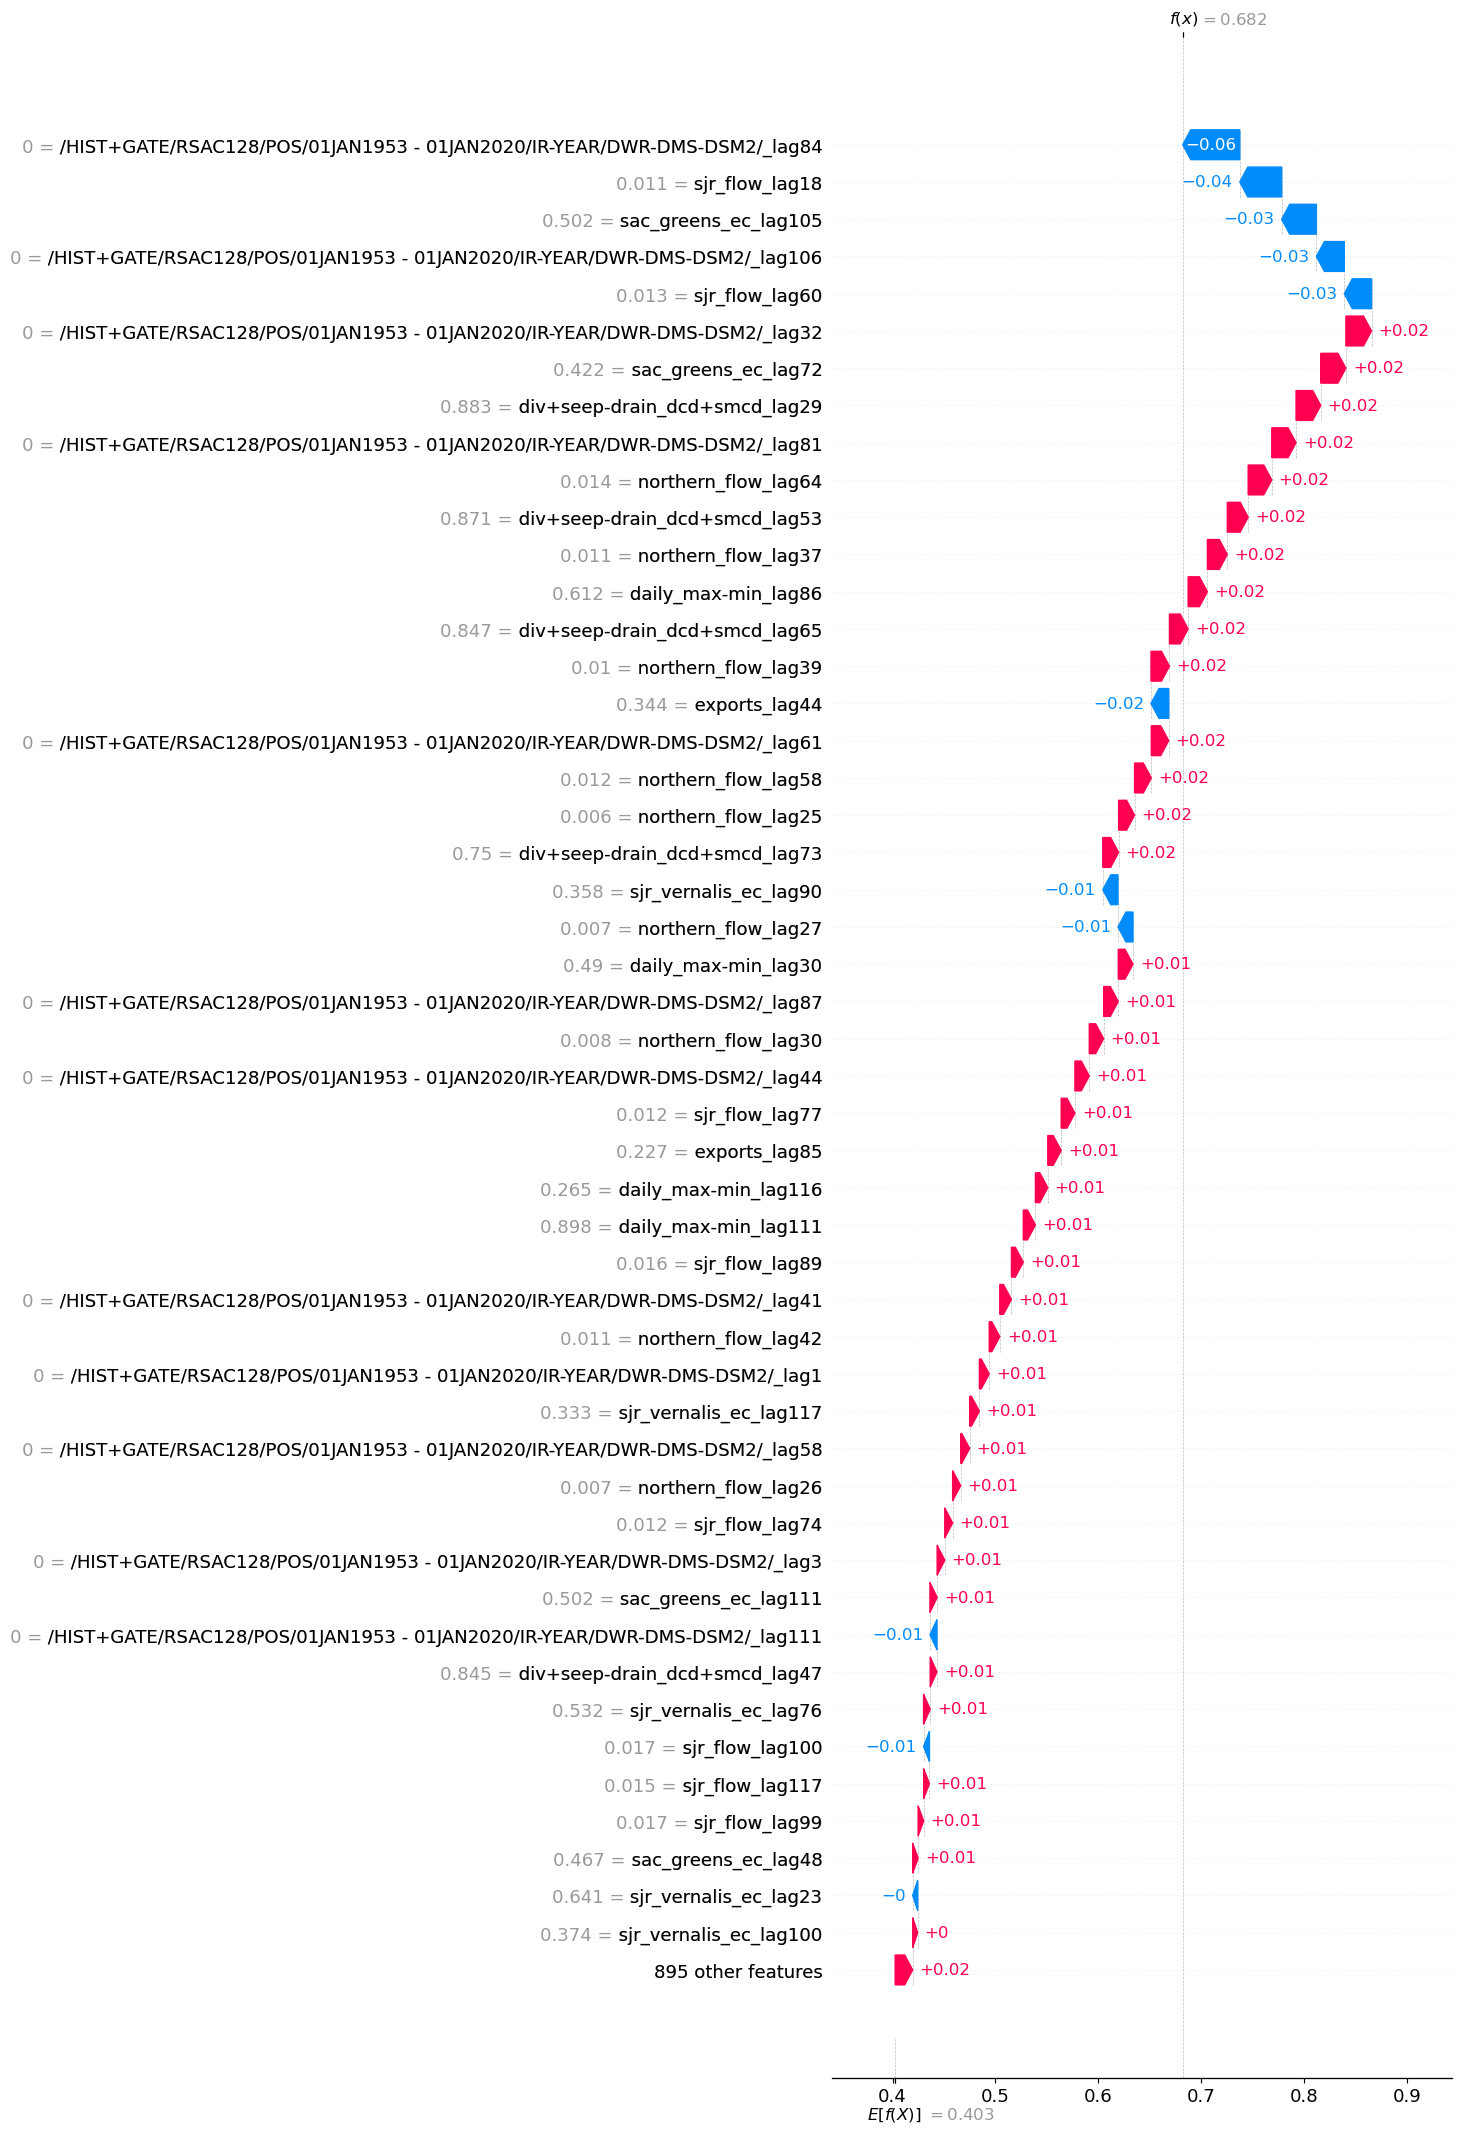

In [17]:

shap.initjs()

class ShapInput(object):
	def __init__(self, expectation, shap_values, features, feat_names):
		self.base_values = expectation
		self.values = shap_values
		self.data = features
		self.feature_names = feat_names
		self.display_data = None

shap_input = ShapInput(explainer.expected_value[0], shap_values[0], xallt.iloc[299,:], feat_names=xallt.columns)

shap.waterfall_plot(shap_input, max_display = 50)

In [22]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0], feature_names=xallt.columns)

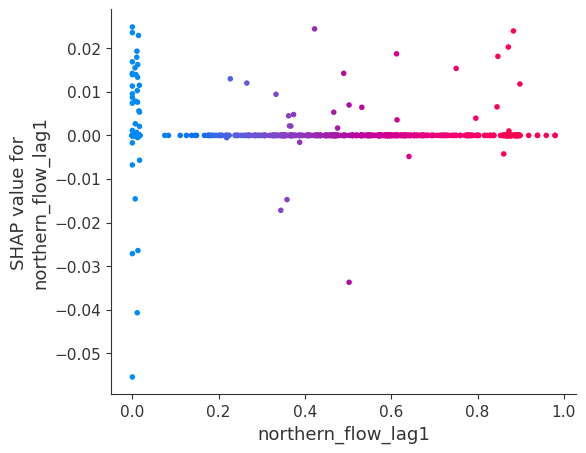

In [37]:
shap2 = shap_values[0].reshape(shap_values[0].shape[0], 1)
feat2 = xallt.iloc[299,:]
# feat2 is a series (944,) get the values as an array (944,1)
feat2 = feat2.values.reshape(feat2.shape[0], 1)
shap.plots._scatter.dependence_legacy(0, shap2 , feat2, feature_names=xallt.columns)

In [48]:
#   ind : int or string
# If this is an int it is the index of the feature to plot. If this is a string it is
# either the name of the feature to plot, or it can have the form "rank(int)" to specify
# the feature with that rank (ordered by mean absolute SHAP value over all the samples).
#
#   shap_values : numpy.array
# Matrix of SHAP values (# samples x # features).
#
# 	features : numpy.array or pandas.DataFrame
# Matrix of feature values (# samples x # features).
#
# 	feature_names : list
# Names of the features (length # features).



loc_index = 4
importance_of_feature = shap_values[loc_index]
num_features = importance_of_feature.shape[0]
shap2 = importance_of_feature.reshape(num_features, 1)

feature_to_plot = 0


# feat2 is a series (944,) get the values as an array (944,1)
feat2 = feat2.values.reshape(feat2.shape[0], 1)
shap.plots._scatter.dependence_legacy(feature_to_plot, shap2 , xallt, feature_names=xallt.columns)


IndexError: index 10925 is out of bounds for axis 0 with size 944